<a href="https://colab.research.google.com/github/stefanogiagu/corso_AI_2024/blob/main/notebooks/es9/MetodiAI_Fis2024_Es9_CNN_Soluzione.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CNNs: classificazione di immagini con una CNN di tipo VGG, e uso di una rete pre-addesrata tramite tecniche di transfer learning

### Informazioni ###

scopo:
- familiarizzare con l'implementazione di CNN in pytorch
- imparare a come sfruttare modelli SOTA CNN preaddestrati su imagnet per task specifiche utilizzando la tecnica del transfer learning

DL tool: pytorch

**Dataset:**

Sign Language Digits Dataset
(Turkey Ankara Ayrancı Anadolu High School Students: [github-link](https://github.com/ardamavi/Sign-Language-Digits-Dataset))

Image size: 100 x 100 pixels

Color space: RGB
Number of classes: 10 (Digits: 0-9)
Number of participant students: 218
Number of samples per student: 10

In [ ]:
#@title Download del dataset (esegui la cella)
!rm -rf Dataset.zip
!rm -rf Dataset_test.zip
!rm -rf Dataset
!rm -rf Dataset_test
!wget http://giagu.web.cern.ch/giagu/CERN/Dataset.zip
!wget http://giagu.web.cern.ch/giagu/CERN/Dataset_test.zip
!unzip -q Dataset.zip
!unzip -q Dataset_test.zip
!rm -rf __MACOSX

--2024-05-12 14:55:04--  http://giagu.web.cern.ch/giagu/CERN/Dataset.zip
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.21.205, 2001:1458:d00:34::100:59
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.21.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11254421 (11M) [application/zip]
Saving to: ‘Dataset.zip’

Dataset.zip         100%[===================>]  10.73M  1.04MB/s    in 16s     

2024-05-12 14:55:21 (707 KB/s) - ‘Dataset.zip’ saved [11254421/11254421]

--2024-05-12 14:55:21--  http://giagu.web.cern.ch/giagu/CERN/Dataset_test.zip
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.21.205, 2001:1458:d00:34::100:59
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.21.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5903386 (5.6M) [application/zip]
Saving to: ‘Dataset_test.zip’

Dataset_test.zip    100%[===================>]   5.63M   530KB/s    in 19s     

2024-05-12 14:55:41 (298 K

Nei folder Dataset e Dataset_test sono contenute le immagini in formato jpeg. Le immagini corrispondenti ai differenti numeri (0,1,2,3,4,5,6,7,9) sono inserite in sub-folders nominati in accordo al digit corrispondente ...

In [ ]:
!ls Dataset/
!ls Dataset_test/
!ls Dataset/0/

0  1  2  3  4  5  6  7	8  9
0  1  2  3  4  5  6  7	8  9
IMG_1118.JPG  IMG_1290.JPG  IMG_5152.JPG  IMG_5328.JPG	IMG_5517.JPG  IMG_5695.JPG  IMG_5867.JPG
IMG_1128.JPG  IMG_1301.JPG  IMG_5163.JPG  IMG_5341.JPG	IMG_5527.JPG  IMG_5705.JPG  IMG_5877.JPG
IMG_1138.JPG  IMG_1312.JPG  IMG_5173.JPG  IMG_5350.JPG	IMG_5537.JPG  IMG_5716.JPG  IMG_5887.JPG
IMG_1148.JPG  IMG_1322.JPG  IMG_5183.JPG  IMG_5360.JPG	IMG_5547.JPG  IMG_5726.JPG  IMG_5897.JPG
IMG_1158.JPG  IMG_5007.JPG  IMG_5193.JPG  IMG_5370.JPG	IMG_5562.JPG  IMG_5736.JPG  IMG_5907.JPG
IMG_1169.JPG  IMG_5017.JPG  IMG_5203.JPG  IMG_5380.JPG	IMG_5572.JPG  IMG_5746.JPG  IMG_5918.JPG
IMG_1179.JPG  IMG_5028.JPG  IMG_5213.JPG  IMG_5390.JPG	IMG_5582.JPG  IMG_5756.JPG  IMG_5928.JPG
IMG_1189.JPG  IMG_5042.JPG  IMG_5223.JPG  IMG_5400.JPG	IMG_5592.JPG  IMG_5766.JPG  IMG_5938.JPG
IMG_1199.JPG  IMG_5053.JPG  IMG_5234.JPG  IMG_5412.JPG	IMG_5603.JPG  IMG_5776.JPG  IMG_5950.JPG
IMG_1209.JPG  IMG_5063.JPG  IMG_5244.JPG  IMG_5422.JPG	IMG_5615.JPG  IMG_5786.JP

## Part 0: lettura del dataset, e preparazione dei dataloader pytorch

In [ ]:
#import
import os.path
from torchsummary import summary

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

2.2.1+cu121
0.17.1+cu121


In [ ]:
# lettura dei dati usando torchvision

data_dir = 'Dataset'
test_dir = 'Dataset_test'

# definizione di un torchvision transform costituito da una composizione di trasformazioni utili
# di processamento dei dati e data augmentation

train_transforms = transforms.Compose([#transforms.RandomRotation(10), #applica una rotazione random +/- 10 deg
                                       #transforms.RandomHorizontalFlip(), #applica un flip random dei pixel orizontal
                                       transforms.Resize((100,100)), #assicura che l'immagine sia 100x100
                                       transforms.ToTensor(), #converte in tensori torch
                                      ])

# la data augmentation è applicata solo alle immagini di training
test_transforms = test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                      ])


# trochvision.datasets mette a disposizione la funzione ImageFolder che permete di creare un dataset a partire da imagini
# salvate in folder sul filesystem, automaticamente associa label alle immagini se queste sono salvate in
# subfolders
# https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
testing_data = datasets.ImageFolder(test_dir, transform=test_transforms)

print(train_data)
print(testing_data)

# split test set in vali e test
test_data, vali_data = torch.utils.data.random_split(testing_data, [450, 455]) #oppure [0.5,0.5] per 50%-50%

print('Trainign set size: ', len(train_data))
print('Validation set size: ',len(vali_data))
print('Test set size: ',len(test_data))

# dataloaders

batch_size = 64
dataloaders = dict() #usiamo un dizionario epr comodità
dataloaders['train'] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloaders['vali'] = torch.utils.data.DataLoader(vali_data, batch_size=batch_size, shuffle=True)
dataloaders['test'] = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

Dataset ImageFolder
    Number of datapoints: 1157
    Root location: Dataset
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 905
    Root location: Dataset_test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Trainign set size:  1157
Validation set size:  455
Test set size:  450


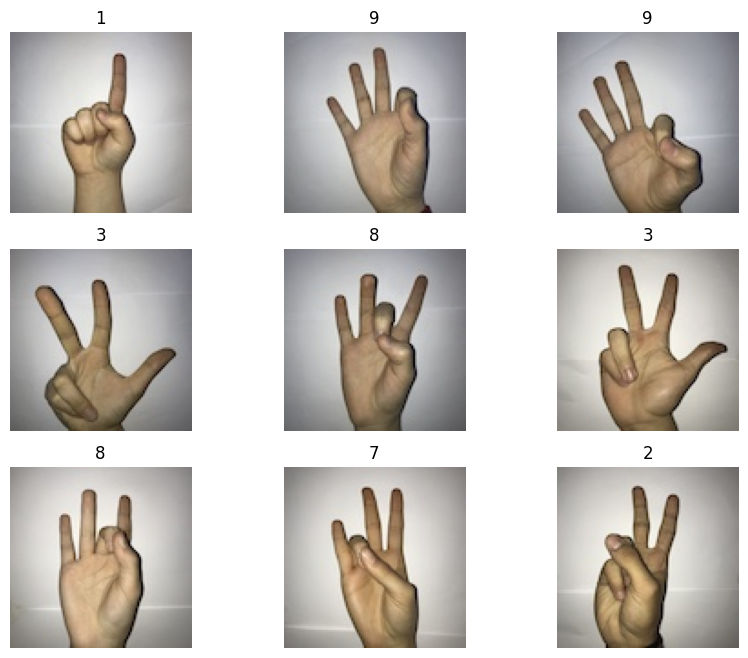

In [ ]:
# plot di alcune delle immagini

figure = plt.figure(figsize=(10, 8))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0)) #nota: imshow si aspetta immagin con shape (h,w,channel) mentre i tensori torch hanno shape (channel, h, w)
plt.show()

In [ ]:
# controlliamo se la GPU è disponibile e nel caso quale tipo di GPU
if torch.cuda.is_available():
  print('Numero di GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Numero di GPU disponibili:  1
Tesla T4
Computation device: cuda



In [ ]:
# Convolutional Neural Network (VGG-like architecture)

from torch import nn
import torch.nn.functional as F

class myVGG(nn.Module):
  def __init__(self):
    super(myVGG, self).__init__()

    # definizione dei layers

    # primo blocco convoluzionale
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3))
    self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

    # secondo blocco convoluzionale
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3))
    self.pool2 = nn.MaxPool2d(kernel_size=(2,2))

    # primo blocco convoluzionale
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3))
    self.pool3 = nn.MaxPool2d(kernel_size=(2,2))

    # MLP
    self.flatten = nn.Flatten() #flatten layer
    self.drop1 = nn.Dropout(p=0.5) #droput
    self.fc1 = nn.Linear(in_features=3200, out_features=64)
    self.drop2 = nn.Dropout(p=0.5) #dropout
    self.fc2 = nn.Linear(in_features=64, out_features=64)
    self.fc3 = nn.Linear(in_features=64, out_features=10)

  # forward pass: x (input) -> out
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    x = self.pool3(x)

    #flatten
    x = self.flatten(x)

    x = self.drop1(x)
    x = F.relu(self.fc1(x))
    x = self.drop2(x)
    x = F.relu(self.fc2(x))

    out = self.fc3(x)
    #out = F.log_softmax(x, dim=1)

    return out

In [ ]:
# printout del modello

model = myVGG()
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(3,100,100))
else:
  summary(model, input_size=(3,100,100))

myVGG(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3200, out_features=64, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 98, 98]             448
         MaxPool2d-2           [-1, 16, 49, 49]               0
            Conv2d-3           [-1, 16, 47, 47]   

In [ ]:
# test di un batch sul modello non addestrato per vedere che le cose funzionino

feat, label = next(iter(dataloaders['train']))

feat=feat.to(device)
label=label.to(device)

out = model(feat)

print(out.shape)
print(out[0])

torch.Size([64, 10])
tensor([ 0.0833,  0.0821, -0.0465, -0.1549,  0.0123,  0.1413, -0.0061,  0.1235,
         0.0989, -0.0499], device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
#install torchmetrics: collection of useful PyTorch metrics implementations and an easy-to-use API to create custom metrics
%pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 11.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
# loss function, accuracy, optimzer

# loss function
loss_func = nn.CrossEntropyLoss() #cross entropy loss
#loss_func = nn.NLLLoss()

# metric accuracy
from torchmetrics.classification import Accuracy

metric_fun = Accuracy(task="multiclass", num_classes=10)
metric_fun = metric_fun.to(device) #NOTA: va spostata anche essa nel device in cui si esegue il cacolo e sono presenti i tensori

# ottmizzatore: usiamo Adam
from torch import optim
LR_ST = 1e-3
opt = optim.Adam(model.parameters(), lr=LR_ST)

# aggiungiamo uno scheduler per il LR che diminusice il LR a intervalli fissati
# ogni 15 epoche riduce il learning rate di un fattore gamma: lr = lr*gamma
scheduler = optim.lr_scheduler.StepLR(opt, 15, gamma=0.1, last_epoch=-1, verbose=True)

In [ ]:
# Checkpoints functions
# attraverso i checkpoints possiamo interagire con il modello durante il run-time
# Per esempio si puo' salvare il modello ad ogni epoca

# Checkpoint per salvare il modello durante il training (solo il best model)
# salviamo non solo il modello ma anche alcuni metadati addizionali che possono essere utili
# salviamo le informazioni in un dizionario python che associa a diverse chiavi diverse
# informazioni
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss

            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")

            # method to save a model (the state_dict: a python dictionary object that
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html

            torch.save({'model' : model,
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, 'best_model.pt')

In [ ]:
# Training function
import time

def train_model(nn_model, criterion, metric, n_epochs, dl_train, dl_vali):


  # liste su cui salvare il valore della loss e della metrica ad ogni epoca per poterli graficare in funzione
  # dell'epoca a fine addestramento
  hist_loss = []
  hist_metric = []
  hist_vloss = []
  hist_vmetric = []


  # loop sulle epoche
  for epoch in range(n_epochs):
    t0 = time.time()

    # training step (in cui aggiorniamo i pesi della rete neurale)
    model.train()
    train_loss = 0
    train_metric = 0
    counter = 0
    for xb, yb in dl_train:
        counter += 1
        xb=xb.to(device) #copio il mini batch di dati sulla CPU/GPU
        yb=yb.to(device)

        pred = nn_model(xb) #predizione del modello

        # calcolo loss e metrica
        loss = criterion(pred, yb)
        if metric != None:
          tmetric = metric(pred, yb)

        # aggiorno la loss e metrica totale
        train_loss += loss.item()
        if metric != None:
          train_metric += tmetric.item()

        # backpropagation
        opt.zero_grad() #resetta i gradienti prima di eseguire la backpropagation (importante!)
        loss.backward() #calcola i gradeinti della loss
        opt.step() #aggiorna i pesi


    train_loss /= counter
    hist_loss.append(train_loss)

    if metric != None:
      train_metric /= counter
      hist_metric.append(train_metric)


    # validation step (non vengono aggiornati i pesi)
    model.eval()
    vali_loss = 0
    vali_metric = 0
    counter = 0
    with torch.no_grad(): #evita che vengano cacolati automaticamente i gradienti
      for xb, yb in dl_vali:
        counter += 1
        xb=xb.to(device)
        yb=yb.to(device)

        pred = nn_model(xb) #predizione del modello

        # calcolo loss e metrica
        vloss = criterion(pred, yb)
        vali_loss += vloss.item()

        if metric != None:
          vmetric = metric(pred, yb)
          vali_metric += vmetric.item()

    vali_loss /= counter
    hist_vloss.append(vali_loss)

    if metric != None:
      vali_metric /= counter
      hist_vmetric.append(vali_metric)


    elapsed_time = time.time()-t0
    if metric != None:
      print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f"
            % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))
    else:
      print("epoch: %d, time(s): %.4f, train loss: %.6f, vali loss: %.6f"
            % (epoch+1, elapsed_time, train_loss, vali_loss))


    # save best model
    save_best_model(vali_loss, epoch, model, opt, loss_func, metric_func)

    # update learning rate schedule
    scheduler.step()

  return nn_model, hist_loss, hist_metric, hist_vloss, hist_vmetric

In [ ]:
# Training

model = myVGG()
model.to(device)
opt = optim.Adam(model.parameters(), lr=LR_ST)
scheduler = optim.lr_scheduler.StepLR(opt, 15, gamma=0.1, last_epoch=-1, verbose=True)
metric_fun = metric_fun.to(device)

# numero di epoche
epochs = 40

# istanzia il save_best_model
save_best_model = SaveBestModel()

model, hist_loss, hist_metric, hist_vloss, hist_vmetric = train_model(nn_model=model, criterion=loss_func, metric=metric_fun, n_epochs=epochs, dl_train=dataloaders['train'], dl_vali=dataloaders['vali'])


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


epoch: 1, time(s): 2.0572, train loss: 2.305090, train metric: 0.092928, vali loss: 2.301955, vali metric: 0.093750
epoch: 2, time(s): 1.7149, train loss: 2.300050, train metric: 0.103618, vali loss: 2.280526, vali metric: 0.127232
epoch: 3, time(s): 1.8773, train loss: 2.212804, train metric: 0.200658, vali loss: 1.971285, vali metric: 0.385324
epoch: 4, time(s): 2.2307, train loss: 1.842566, train metric: 0.294901, vali loss: 1.314060, vali metric: 0.604911
epoch: 5, time(s): 1.7653, train loss: 1.571829, train metric: 0.420559, vali loss: 1.068845, vali metric: 0.651507
epoch: 6, time(s): 1.7338, train loss: 1.372173, train metric: 0.509375, vali loss: 0.787532, vali metric: 0.773158
epoch: 7, time(s): 1.6938, train loss: 1.243401, train metric: 0.552138, vali loss: 0.724391, vali metric: 0.808315
epoch: 8, time(s): 1.7457, train loss: 1.174851, train metric: 0.594737, vali loss: 0.710499, vali metric: 0.779018
epoch: 9, time(s): 1.7249, train loss: 1.096988, train metric: 0.596711,

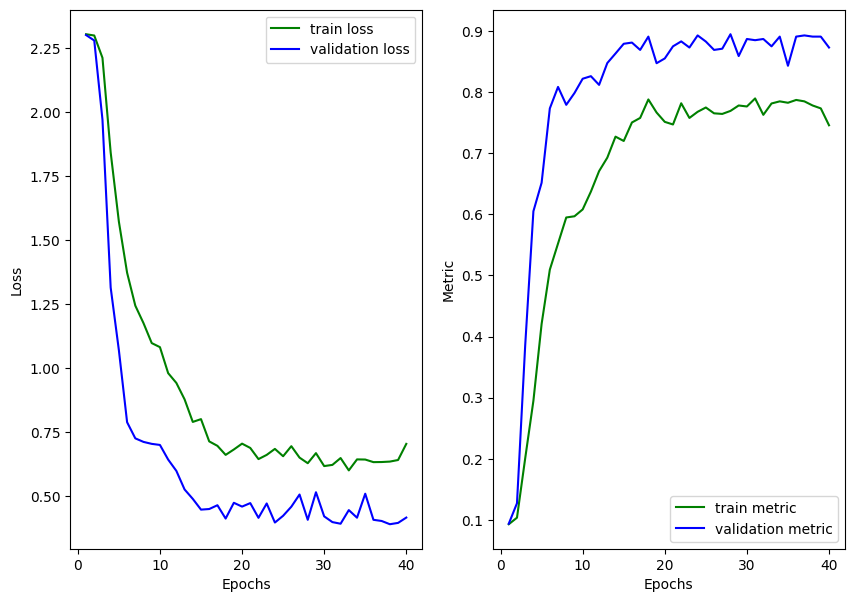

In [ ]:
# grafico monitoring training
plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1),hist_metric, color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [ ]:
# test set perfromance

# lettura del modello
model_data = torch.load('./best_model.pt')
print('Best model at epoch: ', model_data['epoch'])
model = model_data['model']
model.eval() #va sempre fatto per settare eventuali layer di droput e batch norm in evaluation model

# Non è strettamento necessario girare sulla GPU per l'inferenza (non richiede grande potenza di calcolo)
model.to(torch.device('cpu'))
metric_fun = metric_fun.to('cpu')

loss = 0
metric = 0
counter = 0

for xb, yb in dataloaders['test']:
  counter += 1
  xb=xb.to('cpu')
  yb=yb.to('cpu')
  pred = model(xb)

  loss += loss_func(pred, yb).item()
  metric += metric_fun(pred, yb).item()


loss /= counter
metric /= counter

print('Test loss/accuracy: ',loss, ' / ', metric)

Best model at epoch:  31
Test loss/accuracy:  0.47460890421643853  /  0.86328125


In [ ]:
#confusion matrix

#nice printout
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()

    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

predictions = np.empty(shape=(0,))
truths = np.empty(shape=(0,))

for xb, yb in dataloaders['test']:
  counter += 1
  xb=xb.to('cpu')
  yb=yb.to('cpu')
  pred = model(xb)

  res = torch.argmax(pred, dim=1)

  predictions = np.concatenate((predictions,res.detach().numpy()))
  truths = np.concatenate((truths,yb.detach().numpy()))

from sklearn.metrics import confusion_matrix
c_mat = confusion_matrix(predictions, truths, normalize='true')
print("Confusion Matrix:")
labels = ['0','1','2','3','4','5','6','7','8','9']
print_cm(c_mat, labels)

Confusion Matrix:
              0     1     2     3     4     5     6     7     8     9 
        0  0.98  0.00  0.00  0.00  0.02  0.00  0.00  0.00  0.00  0.00 
        1  0.05  0.91  0.00  0.02  0.00  0.00  0.00  0.00  0.00  0.02 
        2  0.00  0.00  0.87  0.04  0.00  0.00  0.09  0.00  0.00  0.00 
        3  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00 
        4  0.00  0.00  0.00  0.00  0.70  0.00  0.09  0.19  0.02  0.00 
        5  0.00  0.00  0.00  0.02  0.00  0.88  0.00  0.00  0.02  0.08 
        6  0.00  0.00  0.03  0.00  0.11  0.00  0.86  0.00  0.00  0.00 
        7  0.03  0.03  0.03  0.00  0.05  0.00  0.03  0.82  0.03  0.00 
        8  0.00  0.01  0.03  0.00  0.09  0.03  0.07  0.07  0.66  0.03 
        9  0.00  0.00  0.00  0.00  0.00  0.11  0.00  0.00  0.00  0.89 


### Risolviamo la task di classificazione utilizzando una rete CNN preaddestrata su un grande dataset (imagenet) e applicando una tecnica di transfer learning:


1.   si definisce e carica iun modello preaddestrato da pytroch
2.   si modifica l'MLP finale del modello adattandolo al nostro task specifico (per esempio classificazione a 10 classi)
3.   si congelano i pesi dei blocchi convoluzionali e si addestra solo l'MLP sul nostro dataset
4.   si rilasciano i pesi dei layer convoluzionali e si fa un fine tuning (training di poche eopoche con un learning rate molto piccolo)



In [ ]:
# carichiamo uno dei modelli preaddestrati da torchvision
from torchvision import datasets, transforms, models

# esempio densenet121
model = models.densenet121(pretrained= True)

print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# congelo i parametri del modello

for param in model.parameters():
    param.requires_grad = False

# aggiungo l'MLP per la classificazione

# OrderedDict è una versione più sofisiticata dei dizionari di python che permette di ricordare l'ordine
# in cui gli elementi sono stati aggiunti al dizionario
from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([
    ('dropout1',nn.Dropout(0.5)),
    # define the inputs must be 1024 for densent121 model
    ('fc1',nn.Linear(1024,64)),
    ('relu1', nn.ReLU()),
    ('dropout2',nn.Dropout(0.5)),
    ('fc2',nn.Linear(64,64)),
    ('relu2', nn.ReLU()),
    ('output',nn.Linear(64,10)),
    #('output', nn.LogSoftmax(dim=1))
]))

model.classifier = classifier

In [ ]:
# loss e ottmizzatore

loss_func = nn.CrossEntropyLoss() #cross entropy loss
# loss_func = nn.NLLLoss()

# metric accuracy
from torchmetrics.classification import Accuracy

metric_fun = Accuracy(task="multiclass", num_classes=10)
metric_fun = metric_fun.to(device) #NOTA: va spostata anche essa nel device in cui si esegue il cacolo e sono presenti i tensori

# ottmizzatore: usiamo Adam
from torch import optim
LR_ST = 1e-3
opt = optim.Adam(model.parameters(), lr=LR_ST)

In [ ]:
# dati: densenet121 richiede immagini in input didimensione 224x224 (è stato addestrato con immagini
# di imagnet di quella dimensione, dobbiamo fare un resize delle immagini del nostro campione)

# lettura dei dati usando torchvision

data_dir = 'Dataset'
test_dir = 'Dataset_test'

# definizione di un torchvision transform costituito da una composizione di trasformazioni utili
# di processamento dei dati e data augmentation

train_transforms = transforms.Compose([#transforms.RandomRotation(10), #applica una rotazione random +/- 10 deg
                                       #transforms.RandomHorizontalFlip(), #applica un flip random dei pixel orizontal
                                       transforms.Resize((224,224)), #assicura che l'immagine sia 224,224
                                       transforms.ToTensor(), #converte in tensori torch
                                      ])

# la data augmentation è applicata solo alle immagini di training
test_transforms = test_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                      ])


# trochvision.datasets mette a disposizione la funzione ImageFolder che permete di creare un dataset a partire da imagini
# salvate in folder sul filesystem, automaticamente associa label alle immagini se queste sono salvate in
# subfolders
# https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
testing_data = datasets.ImageFolder(test_dir, transform=test_transforms)

print(train_data)
print(testing_data)

# split test set in vali e test
test_data, vali_data = torch.utils.data.random_split(testing_data, [450, 455])

print('Trainign set size: ', len(train_data))
print('Validation set size: ',len(vali_data))
print('Test set size: ',len(test_data))

# dataloaders

batch_size = 64
dataloaders = dict() #usiamo un dizionario epr comodità
dataloaders['train'] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloaders['vali'] = torch.utils.data.DataLoader(vali_data, batch_size=batch_size, shuffle=True)
dataloaders['test'] = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)


Dataset ImageFolder
    Number of datapoints: 1157
    Root location: Dataset
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 905
    Root location: Dataset_test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Trainign set size:  1157
Validation set size:  455
Test set size:  450


In [ ]:
# Training

model.to(device)

# numero di epoche
epochs = 20

model, hist_loss, hist_metric, hist_vloss, hist_vmetric = train_model(nn_model=model, criterion=loss_func, metric=metric_fun, n_epochs=epochs, dl_train=dataloaders['train'], dl_vali=dataloaders['vali'])

epoch: 1, time(s): 9.1458, train loss: 2.296880, train metric: 0.117434, vali loss: 2.261697, vali metric: 0.150391
epoch: 2, time(s): 9.2617, train loss: 2.223634, train metric: 0.184211, vali loss: 2.130037, vali metric: 0.353795
epoch: 3, time(s): 9.3776, train loss: 2.102841, train metric: 0.246711, vali loss: 1.921222, vali metric: 0.469029
epoch: 4, time(s): 9.3506, train loss: 1.903788, train metric: 0.334868, vali loss: 1.700025, vali metric: 0.525112
epoch: 5, time(s): 8.9167, train loss: 1.791508, train metric: 0.357237, vali loss: 1.498019, vali metric: 0.641741
epoch: 6, time(s): 9.3087, train loss: 1.693391, train metric: 0.387336, vali loss: 1.356180, vali metric: 0.698940
epoch: 7, time(s): 9.3641, train loss: 1.560496, train metric: 0.466447, vali loss: 1.188530, vali metric: 0.686663
epoch: 8, time(s): 9.3035, train loss: 1.484182, train metric: 0.457730, vali loss: 1.184875, vali metric: 0.643415
epoch: 9, time(s): 8.9614, train loss: 1.440969, train metric: 0.478289,

In [ ]:
torch.save(model, './densenet121_model.pt')

In [ ]:
# fine tuning: unfrize tutti i pesi, setto lr ad un numero molto piccolo (1e-4 o 1e-5) e riaddestro per poche epoche ...

# NOTA: si continua addestrando il modello precedentemente addestrato, non si crea un nuovo modello
model = torch.load('./densenet121_model.pt')
model.to(device)

for param in model.parameters():
    param.requires_grad = True

LR_ST = 1e-5
opt = optim.Adam(model.parameters(), lr=LR_ST)


# numero di epoche
epochs = 10

model, hist_loss, hist_metric, hist_vloss, hist_vmetric = train_model(nn_model=model, criterion=loss_func, metric=metric_fun, n_epochs=epochs, dl_train=dataloaders['train'], dl_vali=dataloaders['vali'])

epoch: 1, time(s): 14.0237, train loss: 1.077847, train metric: 0.597368, vali loss: 0.627896, vali metric: 0.847377
epoch: 2, time(s): 13.8132, train loss: 0.960877, train metric: 0.627138, vali loss: 0.593776, vali metric: 0.878906
epoch: 3, time(s): 13.9363, train loss: 0.876833, train metric: 0.674013, vali loss: 0.537975, vali metric: 0.864676
epoch: 4, time(s): 13.8659, train loss: 0.860159, train metric: 0.697862, vali loss: 0.473499, vali metric: 0.906250
epoch: 5, time(s): 13.9448, train loss: 0.757261, train metric: 0.727303, vali loss: 0.516420, vali metric: 0.876116
epoch: 6, time(s): 14.1999, train loss: 0.757142, train metric: 0.737336, vali loss: 0.418746, vali metric: 0.923828
epoch: 7, time(s): 14.1073, train loss: 0.673904, train metric: 0.756743, vali loss: 0.423328, vali metric: 0.911830
epoch: 8, time(s): 14.3320, train loss: 0.640429, train metric: 0.772533, vali loss: 0.421446, vali metric: 0.895926
epoch: 9, time(s): 14.0536, train loss: 0.632934, train metric: 

**Compiti addizionali per casa:**

* giocoare con il modello CNN cambiano parametri e/o architettura, eliminare  dropout e/o cambiare probabilità di dropout

* provare a fare transferlearning usando un'atra CNN SOTA preaddestrata, per esempio vgg19, e/o resnet152